In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 1380)
(734160, 1)
validation
(101248, 1380)
(101248, 1)
test
(100432, 1380)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2103297 (8.02 MB)


Trainable params: 2103297 (8.02 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:28 - loss: 0.2044 - STD: 1.8956e-04 - MAE: 0.4419

 4/74 [>.............................] - ETA: 1s - loss: 0.0678 - STD: 3.0510e-04 - MAE: 0.1994  

 6/74 [=>............................] - ETA: 1s - loss: 0.0525 - STD: 2.2809e-04 - MAE: 0.1716

 8/74 [==>...........................] - ETA: 1s - loss: 0.0463 - STD: 1.7632e-04 - MAE: 0.1628

10/74 [===>..........................] - ETA: 1s - loss: 0.0430 - STD: 1.4220e-04 - MAE: 0.1590

12/74 [===>..........................] - ETA: 1s - loss: 0.0408 - STD: 1.1976e-04 - MAE: 0.1565

14/74 [====>.........................] - ETA: 1s - loss: 0.0391 - STD: 1.0436e-04 - MAE: 0.1543

16/74 [=====>........................] - ETA: 1s - loss: 0.0376 - STD: 9.3338e-05 - MAE: 0.1517

18/74 [======>.......................] - ETA: 1s - loss: 0.0361 - STD: 8.5181e-05 - MAE: 0.1486

20/74 [=======>......................] - ETA: 1s - loss: 0.0345 - STD: 7.8926e-05 - MAE: 0.1447

22/74 [=======>......................] - ETA: 1s - loss: 0.0328 - STD: 7.3951e-05 - MAE: 0.1402

24/74 [========>.....................] - ETA: 1s - loss: 0.0311 - STD: 6.9837e-05 - MAE: 0.1351

26/74 [=========>....................] - ETA: 1s - loss: 0.0294 - STD: 6.6410e-05 - MAE: 0.1304

28/74 [==========>...................] - ETA: 1s - loss: 0.0280 - STD: 6.3441e-05 - MAE: 0.1268

30/74 [===========>..................] - ETA: 1s - loss: 0.0269 - STD: 6.0753e-05 - MAE: 0.1242

32/74 [===========>..................] - ETA: 1s - loss: 0.0260 - STD: 5.8243e-05 - MAE: 0.1224

34/74 [============>.................] - ETA: 1s - loss: 0.0251 - STD: 5.5793e-05 - MAE: 0.1206

36/74 [=============>................] - ETA: 1s - loss: 0.0243 - STD: 5.3454e-05 - MAE: 0.1186

38/74 [==============>...............] - ETA: 1s - loss: 0.0235 - STD: 5.1258e-05 - MAE: 0.1165

40/74 [===============>..............] - ETA: 1s - loss: 0.0228 - STD: 4.9198e-05 - MAE: 0.1144

42/74 [================>.............] - ETA: 1s - loss: 0.0224 - STD: 4.7257e-05 - MAE: 0.1124

45/74 [=================>............] - ETA: 1s - loss: 0.0215 - STD: 4.4630e-05 - MAE: 0.1099

48/74 [==================>...........] - ETA: 1s - loss: 0.0208 - STD: 4.2262e-05 - MAE: 0.1077

50/74 [===================>..........] - ETA: 1s - loss: 0.0203 - STD: 4.0877e-05 - MAE: 0.1063

52/74 [====================>.........] - ETA: 0s - loss: 0.0199 - STD: 3.9580e-05 - MAE: 0.1051

54/74 [====================>.........] - ETA: 0s - loss: 0.0195 - STD: 3.8429e-05 - MAE: 0.1040

56/74 [=====================>........] - ETA: 0s - loss: 0.0191 - STD: 3.7369e-05 - MAE: 0.1030

58/74 [======================>.......] - ETA: 0s - loss: 0.0188 - STD: 3.6351e-05 - MAE: 0.1021

60/74 [=======================>......] - ETA: 0s - loss: 0.0185 - STD: 3.5383e-05 - MAE: 0.1013

62/74 [========================>.....] - ETA: 0s - loss: 0.0182 - STD: 3.4525e-05 - MAE: 0.1006

64/74 [========================>.....] - ETA: 0s - loss: 0.0179 - STD: 3.3717e-05 - MAE: 0.0998

66/74 [=========================>....] - ETA: 0s - loss: 0.0176 - STD: 3.2926e-05 - MAE: 0.0991

68/74 [==========================>...] - ETA: 0s - loss: 0.0174 - STD: 3.2193e-05 - MAE: 0.0984

70/74 [===========================>..] - ETA: 0s - loss: 0.0171 - STD: 3.1476e-05 - MAE: 0.0977

72/74 [============================>.] - ETA: 0s - loss: 0.0169 - STD: 3.0815e-05 - MAE: 0.0970

74/74 [==============================] - ETA: 0s - loss: 0.0167 - STD: 3.0161e-05 - MAE: 0.0964

74/74 [==============================] - 5s 51ms/step - loss: 0.0167 - STD: 3.0161e-05 - MAE: 0.0964 - val_loss: 0.0086 - val_STD: 2.4881e-06 - val_MAE: 0.0711


Epoch 2/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0091 - STD: 7.5877e-06 - MAE: 0.0741

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 7.1308e-06 - MAE: 0.0750

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 7.5684e-06 - MAE: 0.0751

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 7.8201e-06 - MAE: 0.0753

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 7.7077e-06 - MAE: 0.0755

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 7.6762e-06 - MAE: 0.0755

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 7.7884e-06 - MAE: 0.0756

16/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 7.7824e-06 - MAE: 0.0756

18/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 7.6324e-06 - MAE: 0.0756

20/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 7.7421e-06 - MAE: 0.0756

22/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 7.8132e-06 - MAE: 0.0756

24/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 7.7228e-06 - MAE: 0.0755

26/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 7.7095e-06 - MAE: 0.0754

28/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 7.7089e-06 - MAE: 0.0754

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 7.7465e-06 - MAE: 0.0754

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 7.7357e-06 - MAE: 0.0755

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 7.7769e-06 - MAE: 0.0755

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 7.7936e-06 - MAE: 0.0755

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 7.7921e-06 - MAE: 0.0755

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.7774e-06 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.6862e-06 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.6287e-06 - MAE: 0.0754

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 7.5533e-06 - MAE: 0.0754

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.5724e-06 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 7.5763e-06 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.5574e-06 - MAE: 0.0754

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.5509e-06 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 7.5275e-06 - MAE: 0.0755

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.5044e-06 - MAE: 0.0755

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 7.4843e-06 - MAE: 0.0755

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.4943e-06 - MAE: 0.0755

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.4944e-06 - MAE: 0.0755

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.4958e-06 - MAE: 0.0755

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.5187e-06 - MAE: 0.0755

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 7.5285e-06 - MAE: 0.0755

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 7.5127e-06 - MAE: 0.0755

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 7.5182e-06 - MAE: 0.0754

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 7.5182e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.0376e-06 - val_MAE: 0.0715


Epoch 3/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0090 - STD: 9.0840e-06 - MAE: 0.0752

 3/74 [>.............................] - ETA: 2s - loss: 0.0091 - STD: 8.3645e-06 - MAE: 0.0753

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 8.0754e-06 - MAE: 0.0755

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 7.8672e-06 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 7.7746e-06 - MAE: 0.0756

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 7.6507e-06 - MAE: 0.0756

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 7.7204e-06 - MAE: 0.0755

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 7.8056e-06 - MAE: 0.0755

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 7.7794e-06 - MAE: 0.0755

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 7.7053e-06 - MAE: 0.0754

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 7.6324e-06 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 7.6101e-06 - MAE: 0.0753

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 7.6499e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 7.7019e-06 - MAE: 0.0753

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 7.7496e-06 - MAE: 0.0754

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 7.6664e-06 - MAE: 0.0754

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 7.6014e-06 - MAE: 0.0754

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 7.6343e-06 - MAE: 0.0754

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 7.6577e-06 - MAE: 0.0754

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.6705e-06 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.7107e-06 - MAE: 0.0753

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 7.7186e-06 - MAE: 0.0754

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 7.7638e-06 - MAE: 0.0754

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.7742e-06 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 7.7365e-06 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.7141e-06 - MAE: 0.0754

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.7374e-06 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 7.7675e-06 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.8337e-06 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 7.8564e-06 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.8975e-06 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.9127e-06 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.9334e-06 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.9364e-06 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 7.9193e-06 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 7.9149e-06 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 7.9084e-06 - MAE: 0.0754

74/74 [==============================] - 3s 38ms/step - loss: 0.0092 - STD: 7.9084e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.3062e-06 - val_MAE: 0.0716


Epoch 4/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0092 - STD: 7.9560e-06 - MAE: 0.0753

 3/74 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 8.5893e-06 - MAE: 0.0755

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 8.8997e-06 - MAE: 0.0755

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 8.6840e-06 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 8.5911e-06 - MAE: 0.0755

11/74 [===>..........................] - ETA: 2s - loss: 0.0093 - STD: 8.5330e-06 - MAE: 0.0756

13/74 [====>.........................] - ETA: 2s - loss: 0.0093 - STD: 8.3731e-06 - MAE: 0.0757

15/74 [=====>........................] - ETA: 1s - loss: 0.0093 - STD: 8.3236e-06 - MAE: 0.0756

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 8.3068e-06 - MAE: 0.0756

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 8.2712e-06 - MAE: 0.0755

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 8.3313e-06 - MAE: 0.0755

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 8.2315e-06 - MAE: 0.0754

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 8.1119e-06 - MAE: 0.0754

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 8.0659e-06 - MAE: 0.0754

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 8.0595e-06 - MAE: 0.0754

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 8.0352e-06 - MAE: 0.0754

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 8.0426e-06 - MAE: 0.0754

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 8.1035e-06 - MAE: 0.0754

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 8.0900e-06 - MAE: 0.0754

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 8.0998e-06 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 8.1778e-06 - MAE: 0.0754

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 8.1265e-06 - MAE: 0.0754

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 8.1559e-06 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 8.1379e-06 - MAE: 0.0754

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 8.1785e-06 - MAE: 0.0754

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 8.1992e-06 - MAE: 0.0754

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 8.2328e-06 - MAE: 0.0754

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 8.2646e-06 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 8.2592e-06 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 8.3201e-06 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 8.3803e-06 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.4455e-06 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 8.5183e-06 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.5582e-06 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.6297e-06 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 8.7033e-06 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 8.7695e-06 - MAE: 0.0754

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 8.7695e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 4.1602e-06 - val_MAE: 0.0715


Epoch 5/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0095 - STD: 1.1440e-05 - MAE: 0.0761

 3/74 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 1.1086e-05 - MAE: 0.0758

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 1.0211e-05 - MAE: 0.0756

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 9.6146e-06 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 9.4474e-06 - MAE: 0.0754

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 9.3191e-06 - MAE: 0.0754

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 9.5148e-06 - MAE: 0.0754

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 9.5783e-06 - MAE: 0.0753

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 9.5693e-06 - MAE: 0.0754

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 9.7658e-06 - MAE: 0.0754

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 9.8022e-06 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 9.8365e-06 - MAE: 0.0754

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 9.9082e-06 - MAE: 0.0754

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 9.9071e-06 - MAE: 0.0754

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.0018e-05 - MAE: 0.0754

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.0085e-05 - MAE: 0.0754

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 1.0040e-05 - MAE: 0.0754

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 1.0013e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 9.9802e-06 - MAE: 0.0755

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 9.9585e-06 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 9.9867e-06 - MAE: 0.0754

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.0010e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 1.0027e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.0045e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.0059e-05 - MAE: 0.0755

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.0055e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.0073e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.0071e-05 - MAE: 0.0755

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.0089e-05 - MAE: 0.0755

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.0076e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0086e-05 - MAE: 0.0755

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0068e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0085e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0114e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.0089e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.0071e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.0058e-05 - MAE: 0.0754

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 1.0058e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 4.6421e-06 - val_MAE: 0.0715


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 9.7275e-06 - MAE: 0.0756

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 9.6490e-06 - MAE: 0.0756

 5/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 1.0195e-05 - MAE: 0.0755

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 1.0300e-05 - MAE: 0.0754

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 1.0403e-05 - MAE: 0.0754

11/74 [===>..........................] - ETA: 2s - loss: 0.0093 - STD: 1.0595e-05 - MAE: 0.0755

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 1.0727e-05 - MAE: 0.0754

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 1.0681e-05 - MAE: 0.0754

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 1.0605e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 1.0751e-05 - MAE: 0.0754

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 1.0856e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 1.0857e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.0933e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.1101e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 1.1206e-05 - MAE: 0.0754

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.1289e-05 - MAE: 0.0754

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 1.1308e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 1.1358e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.1493e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.1558e-05 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.1644e-05 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.1757e-05 - MAE: 0.0753

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 1.1823e-05 - MAE: 0.0753

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.1833e-05 - MAE: 0.0753

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.1892e-05 - MAE: 0.0753

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.1977e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.2069e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.2129e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.2201e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.2235e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2329e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2355e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.2436e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.2492e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.2481e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.2497e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.2530e-05 - MAE: 0.0754

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 1.2530e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 9.3042e-06 - val_MAE: 0.0715


Epoch 7/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0096 - STD: 1.6972e-05 - MAE: 0.0770

 3/74 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 1.6254e-05 - MAE: 0.0758

 6/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 1.6431e-05 - MAE: 0.0756

 8/74 [==>...........................] - ETA: 2s - loss: 0.0093 - STD: 1.6567e-05 - MAE: 0.0755

10/74 [===>..........................] - ETA: 2s - loss: 0.0093 - STD: 1.6923e-05 - MAE: 0.0756

12/74 [===>..........................] - ETA: 1s - loss: 0.0093 - STD: 1.7092e-05 - MAE: 0.0755

14/74 [====>.........................] - ETA: 1s - loss: 0.0093 - STD: 1.7186e-05 - MAE: 0.0755

16/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 1.7427e-05 - MAE: 0.0754

18/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 1.7501e-05 - MAE: 0.0754

20/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 1.7504e-05 - MAE: 0.0754

22/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 1.7671e-05 - MAE: 0.0755

24/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 1.7810e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.7937e-05 - MAE: 0.0754

28/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 1.8066e-05 - MAE: 0.0754

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.8134e-05 - MAE: 0.0754

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.8136e-05 - MAE: 0.0754

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 1.8192e-05 - MAE: 0.0754

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 1.8363e-05 - MAE: 0.0755

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.8568e-05 - MAE: 0.0755

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.8725e-05 - MAE: 0.0755

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.8817e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.8868e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 1.8914e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.9008e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.9082e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.9213e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.9281e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.9400e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.9478e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.9580e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.9710e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.9869e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.0037e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.0203e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.0383e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.0518e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.0677e-05 - MAE: 0.0754

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 2.0677e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.6773e-05 - val_MAE: 0.0714


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 2.6856e-05 - MAE: 0.0757

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 2.7010e-05 - MAE: 0.0752

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 2.8548e-05 - MAE: 0.0754

 7/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 2.8990e-05 - MAE: 0.0757

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 2.9616e-05 - MAE: 0.0755

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 2.9978e-05 - MAE: 0.0756

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 3.0344e-05 - MAE: 0.0755

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 3.0675e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 3.0986e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 3.1388e-05 - MAE: 0.0755

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 3.1790e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 3.2200e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 3.2513e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 3.2936e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 3.3362e-05 - MAE: 0.0754

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 3.3748e-05 - MAE: 0.0754

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 3.4071e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 3.4420e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 3.4788e-05 - MAE: 0.0753

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 3.5177e-05 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 3.5646e-05 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.6140e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 3.6679e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 3.7227e-05 - MAE: 0.0755

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 3.7784e-05 - MAE: 0.0755

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 3.8354e-05 - MAE: 0.0755

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 3.8896e-05 - MAE: 0.0755

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 3.9559e-05 - MAE: 0.0755

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 4.0224e-05 - MAE: 0.0755

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 4.0896e-05 - MAE: 0.0755

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.1646e-05 - MAE: 0.0755

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.2402e-05 - MAE: 0.0755

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.3118e-05 - MAE: 0.0755

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.3853e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.5026e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.5871e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 4.6728e-05 - MAE: 0.0754

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 4.6728e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 5.4690e-05 - val_MAE: 0.0715


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 8.0002e-05 - MAE: 0.0755

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 8.0586e-05 - MAE: 0.0751

 5/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 8.1818e-05 - MAE: 0.0755

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 8.3125e-05 - MAE: 0.0753

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 8.4687e-05 - MAE: 0.0753

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 8.6305e-05 - MAE: 0.0753

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 8.7953e-05 - MAE: 0.0752

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 8.9513e-05 - MAE: 0.0752

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 9.1342e-05 - MAE: 0.0753

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 9.3383e-05 - MAE: 0.0753

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 9.5558e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 9.7620e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.0068e-04 - MAE: 0.0753

28/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 1.0275e-04 - MAE: 0.0753

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.0502e-04 - MAE: 0.0752

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.0737e-04 - MAE: 0.0753

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 1.0985e-04 - MAE: 0.0753

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 1.1242e-04 - MAE: 0.0753

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.1504e-04 - MAE: 0.0753

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.1783e-04 - MAE: 0.0753

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.2063e-04 - MAE: 0.0753

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.2360e-04 - MAE: 0.0753

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 1.2668e-04 - MAE: 0.0753

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.2985e-04 - MAE: 0.0753

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.3316e-04 - MAE: 0.0753

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.3669e-04 - MAE: 0.0753

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.4042e-04 - MAE: 0.0753

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.4434e-04 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.4854e-04 - MAE: 0.0753

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.5274e-04 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.5730e-04 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.6199e-04 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.6701e-04 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.7230e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.7769e-04 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.8356e-04 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.8979e-04 - MAE: 0.0753

74/74 [==============================] - 3s 39ms/step - loss: 0.0092 - STD: 1.8979e-04 - MAE: 0.0753 - val_loss: 0.0086 - val_STD: 3.1826e-04 - val_MAE: 0.0715


Epoch 10/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 4.3140e-04 - MAE: 0.0749

 3/74 [>.............................] - ETA: 2s - loss: 0.0091 - STD: 4.4510e-04 - MAE: 0.0751

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 4.6052e-04 - MAE: 0.0752

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 4.7433e-04 - MAE: 0.0753

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 4.8855e-04 - MAE: 0.0753

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 5.0448e-04 - MAE: 0.0752

13/74 [====>.........................] - ETA: 2s - loss: 0.0092 - STD: 5.2295e-04 - MAE: 0.0753

15/74 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 5.4217e-04 - MAE: 0.0753

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 5.6322e-04 - MAE: 0.0752

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 5.8396e-04 - MAE: 0.0752

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 6.0550e-04 - MAE: 0.0752

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 6.3010e-04 - MAE: 0.0751

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 6.5504e-04 - MAE: 0.0751

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 6.8281e-04 - MAE: 0.0752

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 7.2705e-04 - MAE: 0.0751

32/74 [===========>..................] - ETA: 1s - loss: 0.0091 - STD: 7.5834e-04 - MAE: 0.0751

34/74 [============>.................] - ETA: 1s - loss: 0.0091 - STD: 7.9292e-04 - MAE: 0.0751

36/74 [=============>................] - ETA: 1s - loss: 0.0091 - STD: 8.3005e-04 - MAE: 0.0751

38/74 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 8.7089e-04 - MAE: 0.0750

40/74 [===============>..............] - ETA: 1s - loss: 0.0091 - STD: 9.1417e-04 - MAE: 0.0751

42/74 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 9.6201e-04 - MAE: 0.0751

44/74 [================>.............] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

46/74 [=================>............] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

48/74 [==================>...........] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

50/74 [===================>..........] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

52/74 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

54/74 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

56/74 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0749

58/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0749

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

62/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0748

64/74 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0018 - MAE: 0.0748

66/74 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0748

68/74 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0747

70/74 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0746

72/74 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0746

74/74 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0745

74/74 [==============================] - 3s 39ms/step - loss: 0.0090 - STD: 0.0026 - MAE: 0.0745 - val_loss: 0.0077 - val_STD: 0.0076 - val_MAE: 0.0682


Epoch 11/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0084 - STD: 0.0098 - MAE: 0.0727

 3/74 [>.............................] - ETA: 2s - loss: 0.0083 - STD: 0.0103 - MAE: 0.0718

 5/74 [=>............................] - ETA: 2s - loss: 0.0082 - STD: 0.0109 - MAE: 0.0717

 7/74 [=>............................] - ETA: 2s - loss: 0.0082 - STD: 0.0114 - MAE: 0.0714

 9/74 [==>...........................] - ETA: 2s - loss: 0.0081 - STD: 0.0120 - MAE: 0.0709

11/74 [===>..........................] - ETA: 2s - loss: 0.0081 - STD: 0.0127 - MAE: 0.0709

13/74 [====>.........................] - ETA: 2s - loss: 0.0080 - STD: 0.0133 - MAE: 0.0708

15/74 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.0141 - MAE: 0.0703

17/74 [=====>........................] - ETA: 1s - loss: 0.0079 - STD: 0.0149 - MAE: 0.0701

20/74 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.0162 - MAE: 0.0698

22/74 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.0171 - MAE: 0.0697

24/74 [========>.....................] - ETA: 1s - loss: 0.0078 - STD: 0.0180 - MAE: 0.0694

26/74 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0189 - MAE: 0.0692

28/74 [==========>...................] - ETA: 1s - loss: 0.0076 - STD: 0.0200 - MAE: 0.0689

30/74 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.0209 - MAE: 0.0686

32/74 [===========>..................] - ETA: 1s - loss: 0.0075 - STD: 0.0219 - MAE: 0.0683

34/74 [============>.................] - ETA: 1s - loss: 0.0075 - STD: 0.0230 - MAE: 0.0681

36/74 [=============>................] - ETA: 1s - loss: 0.0074 - STD: 0.0240 - MAE: 0.0678

38/74 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0250 - MAE: 0.0675

40/74 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.0260 - MAE: 0.0673

42/74 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0270 - MAE: 0.0671

44/74 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0280 - MAE: 0.0669

46/74 [=================>............] - ETA: 0s - loss: 0.0072 - STD: 0.0289 - MAE: 0.0667

48/74 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0298 - MAE: 0.0665

50/74 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0307 - MAE: 0.0663

52/74 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0315 - MAE: 0.0661

54/74 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0322 - MAE: 0.0660

56/74 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0329 - MAE: 0.0658

58/74 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0336 - MAE: 0.0657

60/74 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0342 - MAE: 0.0655

62/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0348 - MAE: 0.0654

64/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0353 - MAE: 0.0652

66/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0358 - MAE: 0.0651

68/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0363 - MAE: 0.0650

70/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0367 - MAE: 0.0649

72/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0372 - MAE: 0.0647

74/74 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0377 - MAE: 0.0646

74/74 [==============================] - 3s 39ms/step - loss: 0.0068 - STD: 0.0377 - MAE: 0.0646 - val_loss: 0.0059 - val_STD: 0.0432 - val_MAE: 0.0570


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0517 - MAE: 0.0597

 3/74 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0530 - MAE: 0.0606

 5/74 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0533 - MAE: 0.0612

 7/74 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0525 - MAE: 0.0611

 9/74 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0520 - MAE: 0.0611

11/74 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0519 - MAE: 0.0614

13/74 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0516 - MAE: 0.0612

15/74 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0517 - MAE: 0.0612

17/74 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0518 - MAE: 0.0613

19/74 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0519 - MAE: 0.0611

21/74 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0521 - MAE: 0.0610

23/74 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0523 - MAE: 0.0610

25/74 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0524 - MAE: 0.0609

27/74 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0525 - MAE: 0.0609

29/74 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0526 - MAE: 0.0608

31/74 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0527 - MAE: 0.0608

33/74 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0528 - MAE: 0.0608

35/74 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0529 - MAE: 0.0607

37/74 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0530 - MAE: 0.0607

39/74 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0532 - MAE: 0.0607

41/74 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0532 - MAE: 0.0607

43/74 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0533 - MAE: 0.0607

45/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0533 - MAE: 0.0606

47/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0533 - MAE: 0.0606

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0534 - MAE: 0.0606

51/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0534 - MAE: 0.0606

53/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0535 - MAE: 0.0606

55/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0536 - MAE: 0.0606

58/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0536 - MAE: 0.0605

60/74 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0537 - MAE: 0.0605

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0537 - MAE: 0.0605

64/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0538 - MAE: 0.0605

66/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0538 - MAE: 0.0604

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0538 - MAE: 0.0604

70/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0538 - MAE: 0.0604

72/74 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0539 - MAE: 0.0604

74/74 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0539 - MAE: 0.0604

74/74 [==============================] - 3s 39ms/step - loss: 0.0060 - STD: 0.0539 - MAE: 0.0604 - val_loss: 0.0057 - val_STD: 0.0472 - val_MAE: 0.0571


Epoch 13/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0062 - STD: 0.0575 - MAE: 0.0613

 3/74 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0605

 5/74 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0601

 7/74 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0601

 9/74 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0600

11/74 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0600

13/74 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0600

15/74 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0600

17/74 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0599

19/74 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0599

21/74 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0599

23/74 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0600

25/74 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0600

27/74 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0553 - MAE: 0.0599

29/74 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0599

31/74 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0599

34/74 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0598

36/74 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0553 - MAE: 0.0599

38/74 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0598

40/74 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0598

42/74 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0598

44/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0598

46/74 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0598

48/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0598

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0598

52/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0598

54/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0598

56/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0598

58/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0598

60/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0597

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0597

64/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0597

66/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0597

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0597

70/74 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0597

72/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0597

74/74 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0597

74/74 [==============================] - 3s 38ms/step - loss: 0.0059 - STD: 0.0557 - MAE: 0.0597 - val_loss: 0.0058 - val_STD: 0.0464 - val_MAE: 0.0571


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0563 - MAE: 0.0589

 3/74 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0600

 5/74 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0543 - MAE: 0.0597

 7/74 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0541 - MAE: 0.0597

 9/74 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0547 - MAE: 0.0600

11/74 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0600

13/74 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0600

15/74 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0601

17/74 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0543 - MAE: 0.0600

19/74 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0543 - MAE: 0.0601

21/74 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0602

23/74 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0542 - MAE: 0.0601

25/74 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0601

27/74 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0543 - MAE: 0.0600

29/74 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0600

31/74 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0600

33/74 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0599

35/74 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0599

37/74 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0598

40/74 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0549 - MAE: 0.0598

42/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0550 - MAE: 0.0598

44/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0551 - MAE: 0.0597

46/74 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0551 - MAE: 0.0597

48/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0597

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0597

52/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0553 - MAE: 0.0597

54/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0597

56/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0597

58/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

60/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

64/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

66/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0597

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

70/74 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

72/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0597

74/74 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0556 - MAE: 0.0597

74/74 [==============================] - 3s 35ms/step - loss: 0.0059 - STD: 0.0556 - MAE: 0.0597 - val_loss: 0.0060 - val_STD: 0.0460 - val_MAE: 0.0568


Epoch 15/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0558 - MAE: 0.0581

 3/74 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0590

 5/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0564 - MAE: 0.0589

 7/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

 9/74 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0563 - MAE: 0.0589

11/74 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0563 - MAE: 0.0590

13/74 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0591

15/74 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0590

17/74 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0591

19/74 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0591

21/74 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0590

23/74 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0591

25/74 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

27/74 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0591

30/74 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

32/74 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

34/74 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

36/74 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

38/74 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

40/74 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0591

42/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0590

44/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0590

46/74 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0590

48/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0590

50/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0590

52/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0590

54/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0590

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0590

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0590

60/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0590

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0590

64/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0590

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0590

68/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0590

70/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0590

72/74 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0590

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0590

74/74 [==============================] - 3s 36ms/step - loss: 0.0058 - STD: 0.0571 - MAE: 0.0590 - val_loss: 0.0060 - val_STD: 0.0461 - val_MAE: 0.0568


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0554 - MAE: 0.0579

 3/74 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0592

 5/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0589

 7/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0589

 9/74 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0588

11/74 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0588

13/74 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0587

15/74 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0587

17/74 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0587

19/74 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0587

21/74 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0587

23/74 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0587

25/74 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0587

27/74 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588

29/74 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0587

31/74 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

33/74 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

35/74 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0588

37/74 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

39/74 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

41/74 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

45/74 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

47/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

49/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0590

52/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0590

54/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0590

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0590

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0590

60/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0589

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0590

64/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0589

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

68/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

70/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

72/74 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

74/74 [==============================] - 3s 36ms/step - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589 - val_loss: 0.0058 - val_STD: 0.0492 - val_MAE: 0.0568


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0591

 3/74 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0583 - MAE: 0.0588

 5/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0587

 7/74 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0587

 9/74 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0587

11/74 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0587

13/74 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

15/74 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

18/74 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

20/74 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0587

22/74 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0587

24/74 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0586

26/74 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

28/74 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

30/74 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0586

32/74 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0586

34/74 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0586

36/74 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

38/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

40/74 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

42/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

46/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

50/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

52/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

54/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

58/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

60/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

64/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0586

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0586

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

72/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

74/74 [==============================] - 3s 36ms/step - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586 - val_loss: 0.0061 - val_STD: 0.0448 - val_MAE: 0.0570


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0535 - MAE: 0.0577

 3/74 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0588

 5/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0559 - MAE: 0.0585

 7/74 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0590

 9/74 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0590

12/74 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0588

14/74 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

16/74 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0587

18/74 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

20/74 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

22/74 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0586

24/74 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0585

26/74 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0584

28/74 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0584

30/74 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0584

32/74 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

34/74 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

36/74 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

38/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

40/74 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

42/74 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

46/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0583

50/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

52/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

54/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

58/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0583

60/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

64/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0583

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

72/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

74/74 [==============================] - 3s 36ms/step - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584 - val_loss: 0.0058 - val_STD: 0.0491 - val_MAE: 0.0564


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0579

 3/74 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0581

 5/74 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0582

 7/74 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0583

 9/74 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

11/74 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0581

13/74 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

15/74 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0581

17/74 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

19/74 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0582

21/74 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

23/74 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0581

25/74 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0582

27/74 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

29/74 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

31/74 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

33/74 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

35/74 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

37/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

39/74 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

41/74 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

43/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

45/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

47/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0581

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

57/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

59/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

64/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

72/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

74/74 [==============================] - 3s 36ms/step - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581 - val_loss: 0.0059 - val_STD: 0.0497 - val_MAE: 0.0563


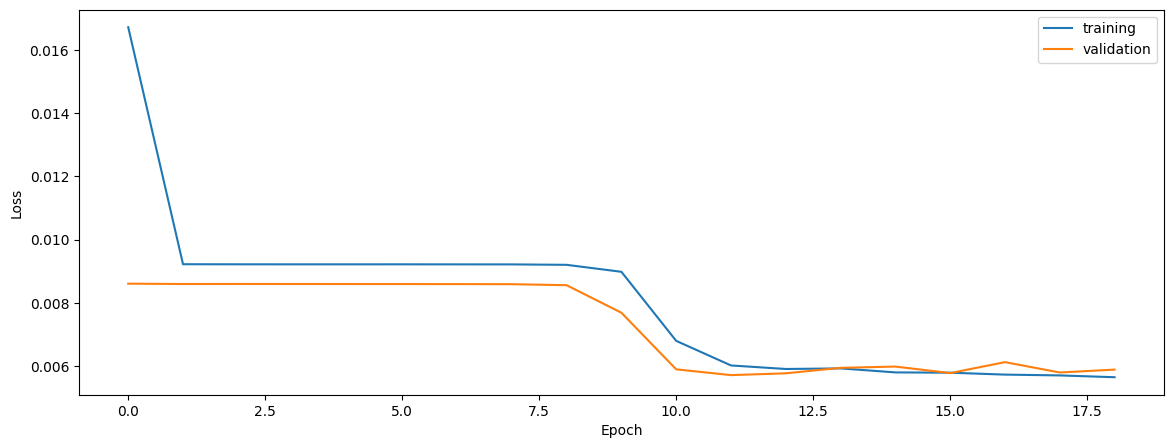

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.5977621453535582
0.5797822813090246
0.5884645266004853


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.5977621453535582
0.5797822813090246
0.5884645266004853


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.5921565290436871
0.5827618965460596
0.5885878164065214


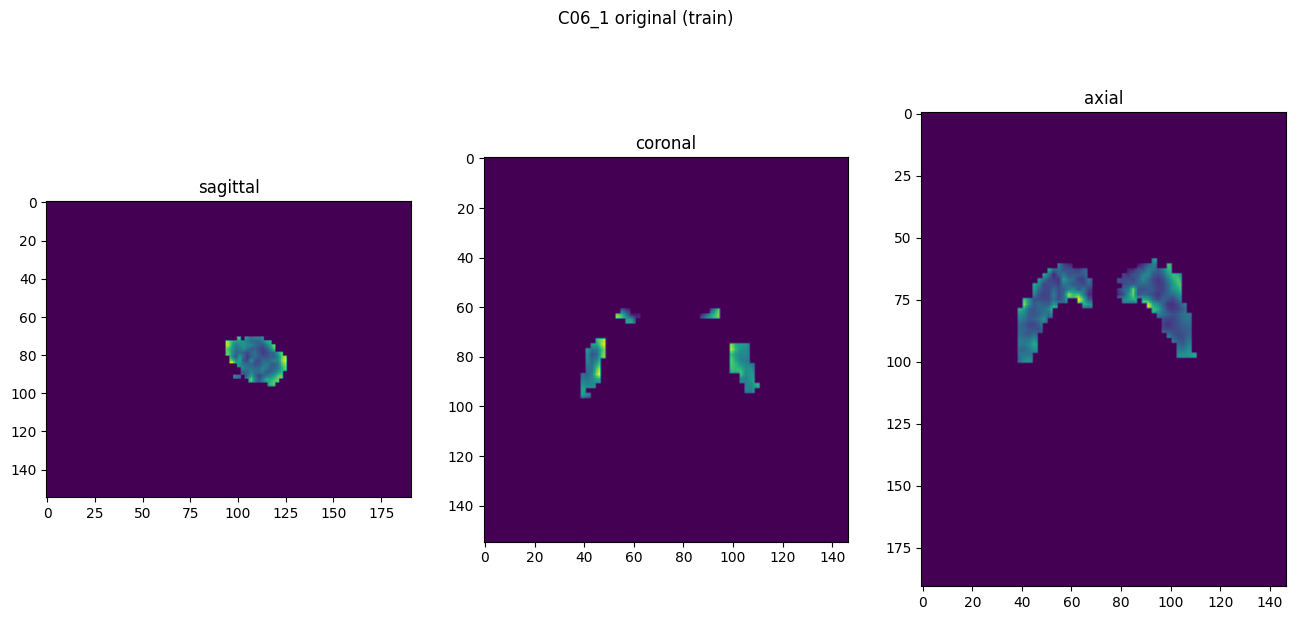

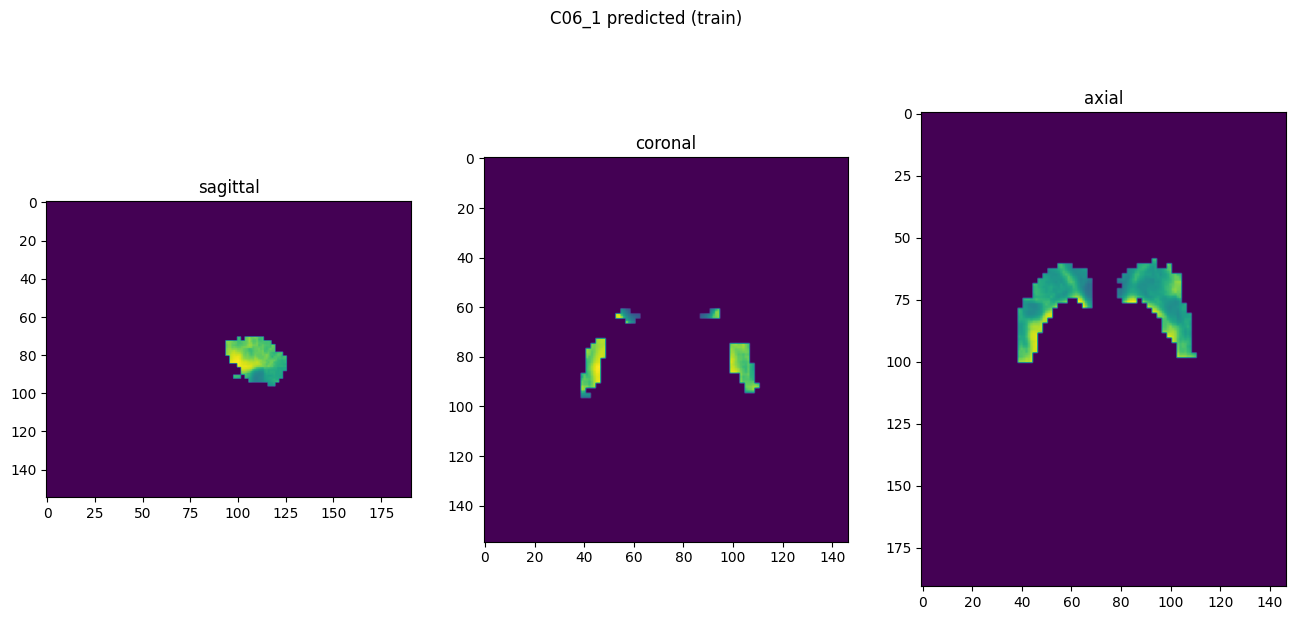

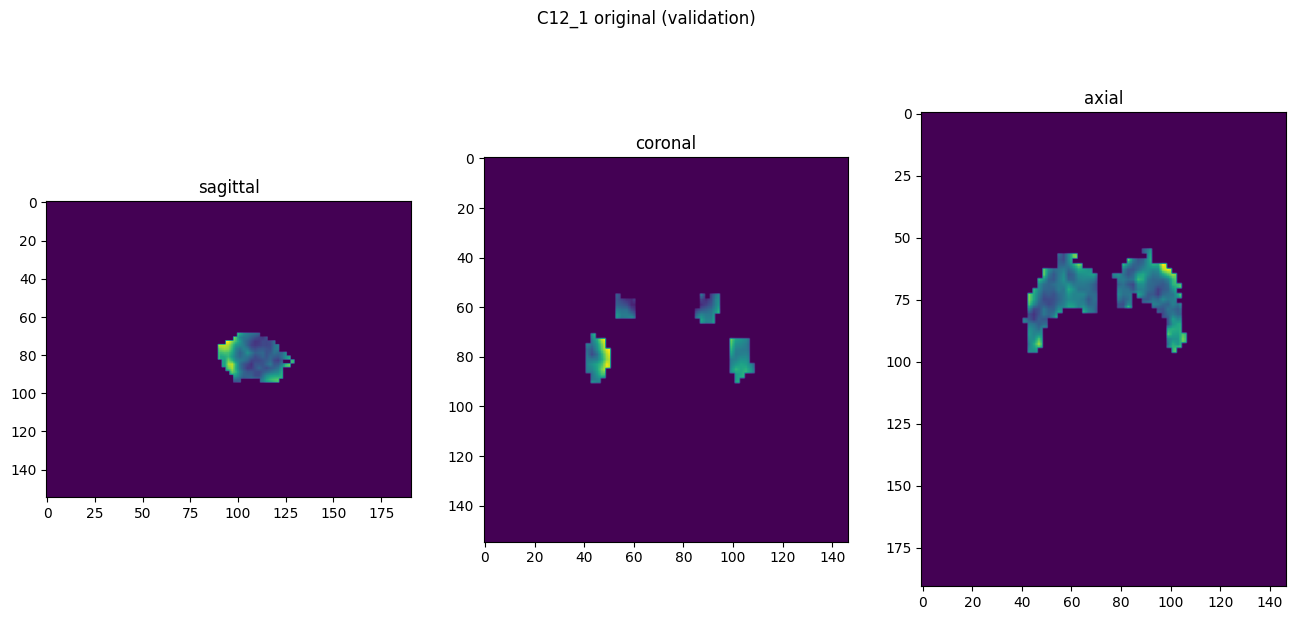

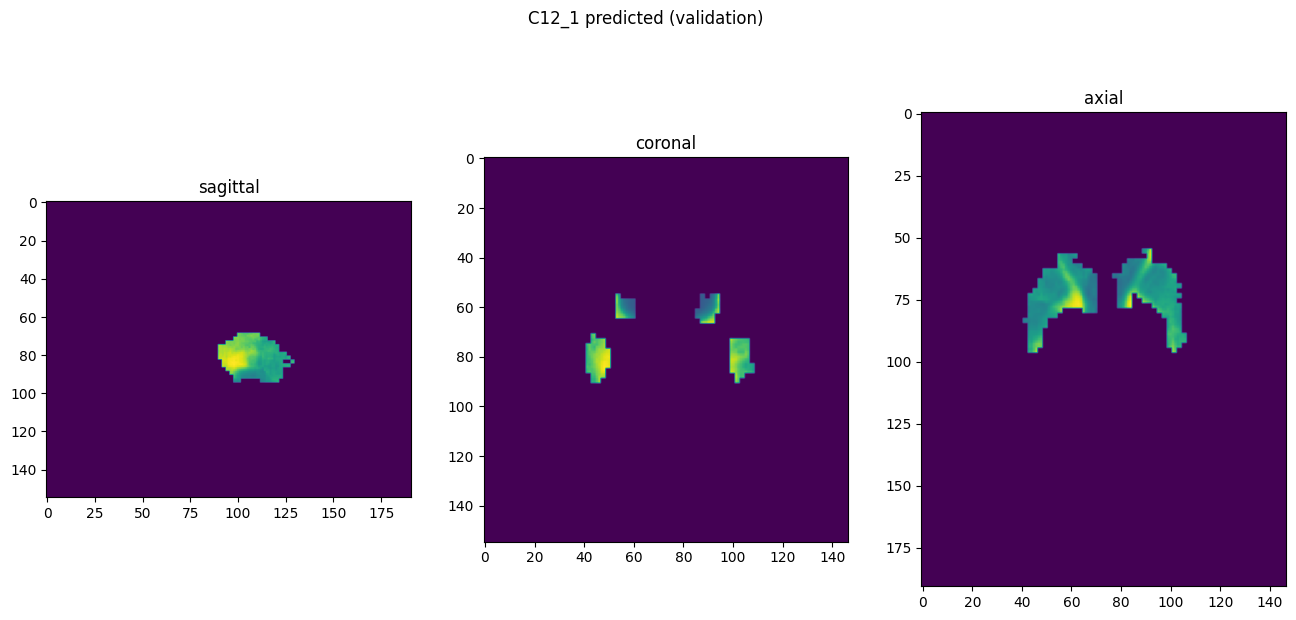

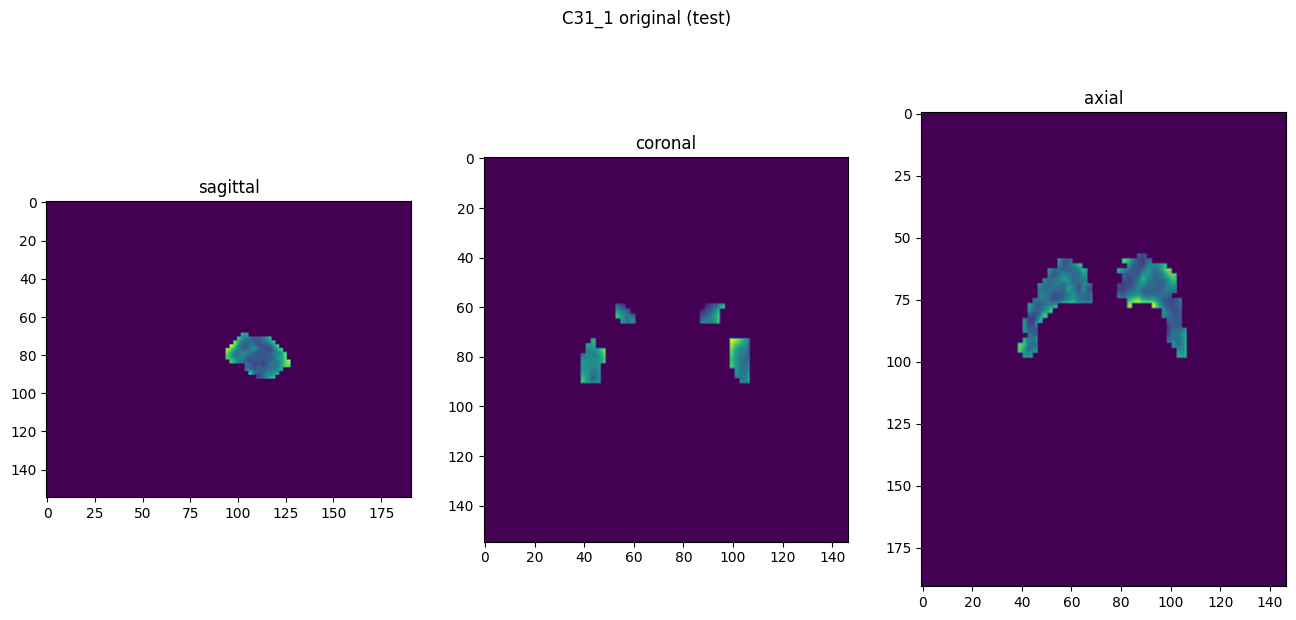

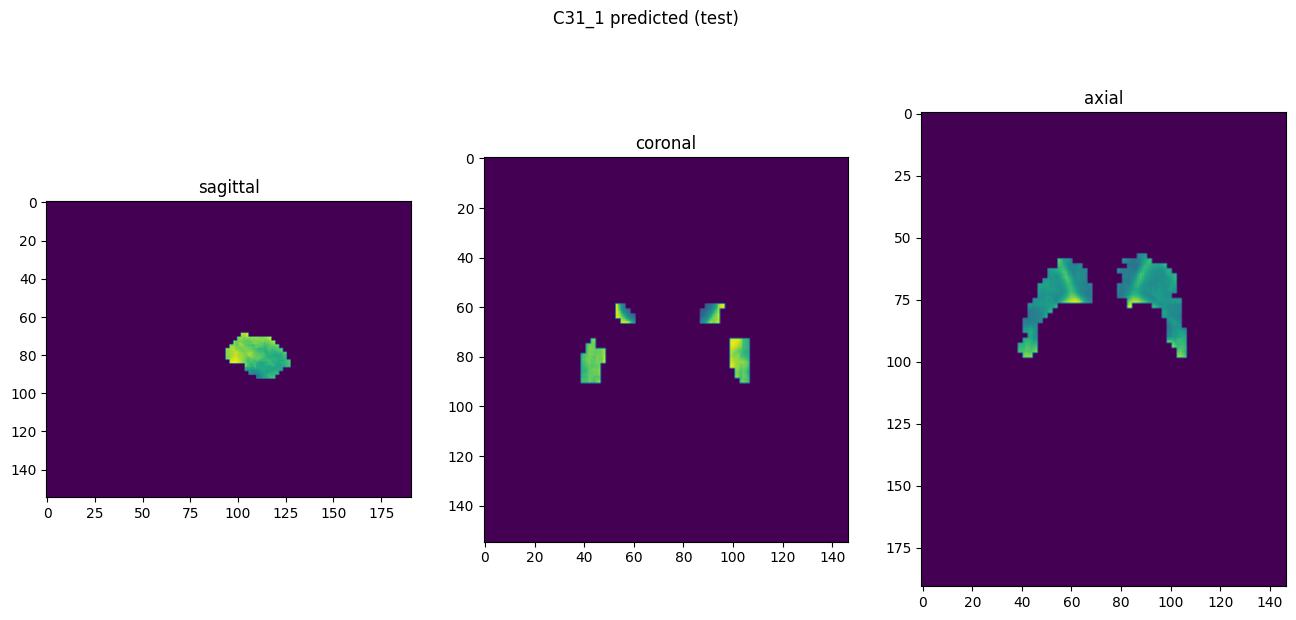

In [10]:
showResults(model, gen, threshold=None, background=False)